In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import time

In [2]:
data = pd.read_csv("output.csv")
df = data.drop(['Time'], axis=1)
number_of_houses = len(df.columns)
df

,PT41CV,PT44AL,PT15VP,PT69QG,PT43QL,PT17RW,PT87ZW
0,0.028,0.452,0.000,0.828,0.128,0.056,0.552
1,0.080,0.440,0.000,0.796,0.160,0.056,0.492
2,0.092,0.424,0.000,0.832,0.220,0.056,0.308
3,0.040,0.408,0.000,0.800,0.404,0.088,0.156
4,0.076,0.396,0.000,0.836,0.156,0.116,0.160
...,...,...,...,...,...,...,...
35027,0.120,0.448,0.108,0.220,0.164,0.144,0.368
35028,0.036,0.424,0.124,0.252,0.228,0.164,0.396
35029,0.064,0.392,0.148,0.268,0.224,0.220,0.356
35030,0.132,0.260,0.132,0.276,0.212,0.176,0.392


## Auxiliary functions

In [17]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    wape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    #wape = mean_absolute_error(actuals, preds) / actuals.mean() * 100
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print('MSE: %.4f' % mse)
    print('WAPE: %.4f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores

In [4]:
def total_averaged_metrics(metrics_list):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAPE: {}".format(np.round(sum(l for i, j, k, l, m in metrics_list)*100/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(m for i, j, k, l, m in metrics_list)/len(metrics_list),3)))

def predict_results(X_train, X_test, y_train, y_test):
    model, preds = build_model(LinearRegression(), X_train, y_train, X_test)
    mse, wape, r2 = performance_metrics(preds, y_test.values.reshape(-1))
    return mse, wape, r2

def last_energy_points(df, number_timesteps):
    X_total = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X_total[f'Energy_{i}'] = df.shift(i)
    X_total.dropna(inplace=True)
    X_total.reset_index(drop=True, inplace=True)
    y_total = pd.DataFrame(df[number_timesteps:])
    y_total.reset_index(drop=True, inplace=True)
    y_total.columns = ["Energy"]
    return X_total, y_total

def prepare_polynomial(X, y, deg):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    poly_features = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, train_size=0.8)
    return X_train, X_test, y_train, y_test

In [5]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [6]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,2.044
1,2.024
2,1.932
3,1.896
4,1.740
...,...
35027,1.572
35028,1.624
35029,1.672
35030,1.580


# Linear Regression

## Test for last 3 hours

In [18]:
metrics_list = []
full_start = time.time()
for i in range(1,13):
    start = time.time()
    print("\nIteration ", i)
    X, y = last_energy_points(df_total, i)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

    mse, wape, r2 = predict_results(X_train, X_test, y_train, y_test)
    metrics_list.append((mse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))
print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))


Iteration  1
MSE: 0.4359
SMAPE: 46.4250
WAPE: 350479.3940
R2: 0.6168

Elapsed time: 1.429 seconds

Iteration  2
MSE: 0.4720
SMAPE: 46.7067
WAPE: 352263.6691
R2: 0.6134

Elapsed time: 0.987 seconds

Iteration  3
MSE: 0.4196
SMAPE: 46.6394
WAPE: 350047.6409
R2: 0.6324

Elapsed time: 0.734 seconds

Iteration  4
MSE: 0.4281
SMAPE: 46.9473
WAPE: 354863.4838
R2: 0.6411

Elapsed time: 0.948 seconds

Iteration  5
MSE: 0.4390
SMAPE: 47.0179
WAPE: 355257.3556
R2: 0.6264

Elapsed time: 0.739 seconds

Iteration  6
MSE: 0.4340
SMAPE: 47.0023
WAPE: 354367.0618
R2: 0.6188

Elapsed time: 0.957 seconds

Iteration  7
MSE: 0.4223
SMAPE: 47.1914
WAPE: 357477.7339
R2: 0.6457

Elapsed time: 0.782 seconds

Iteration  8
MSE: 0.4388
SMAPE: 46.6058
WAPE: 351406.4217
R2: 0.6293

Elapsed time: 0.920 seconds

Iteration  9
MSE: 0.4286
SMAPE: 46.2413
WAPE: 348371.4057
R2: 0.6157

Elapsed time: 0.823 seconds

Iteration  10
MSE: 0.4497
SMAPE: 47.2308
WAPE: 356458.1725
R2: 0.6347

Elapsed time: 0.750 seconds

Iteratio

In [19]:
mse_list = []
wape_list = []
r2_list = []

for i in range(0,12):
    mse_list.append(metrics_list[i][0])
    wape_list.append(metrics_list[i][1])
    r2_list.append(metrics_list[i][2])

## Plot performance metrics

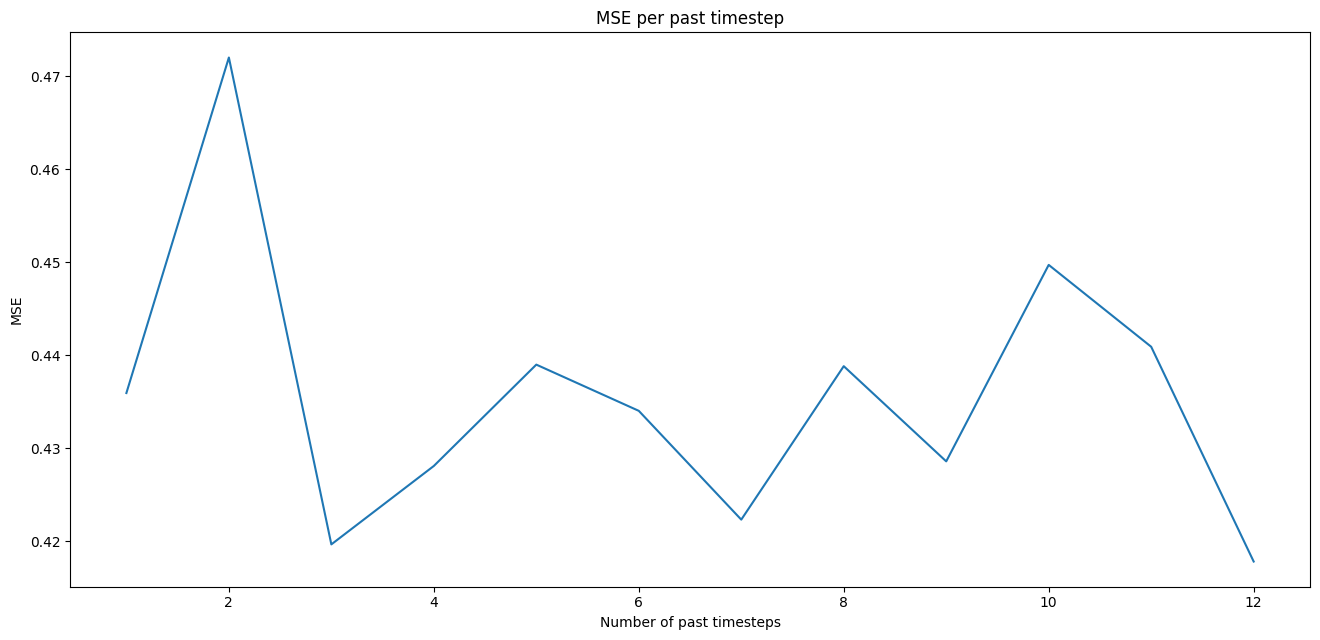

In [20]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), mse_list)
plt.title('MSE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MSE')
plt.show()

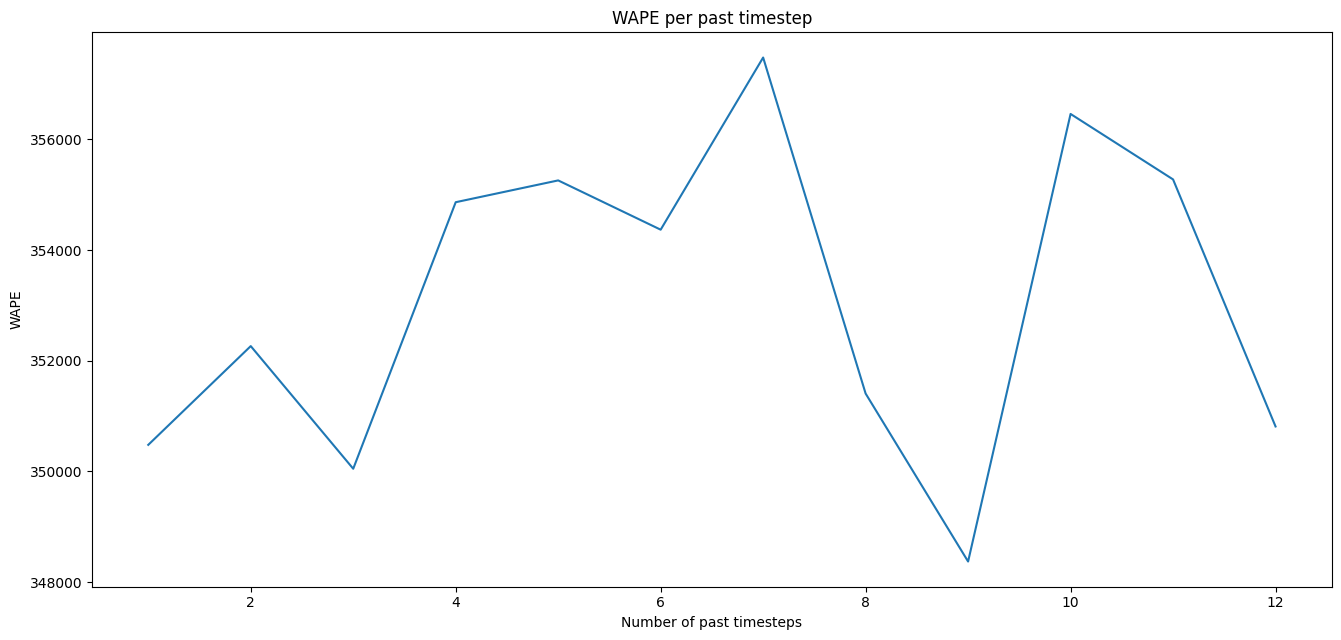

In [21]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), wape_list)
plt.title('WAPE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('WAPE')
plt.show()

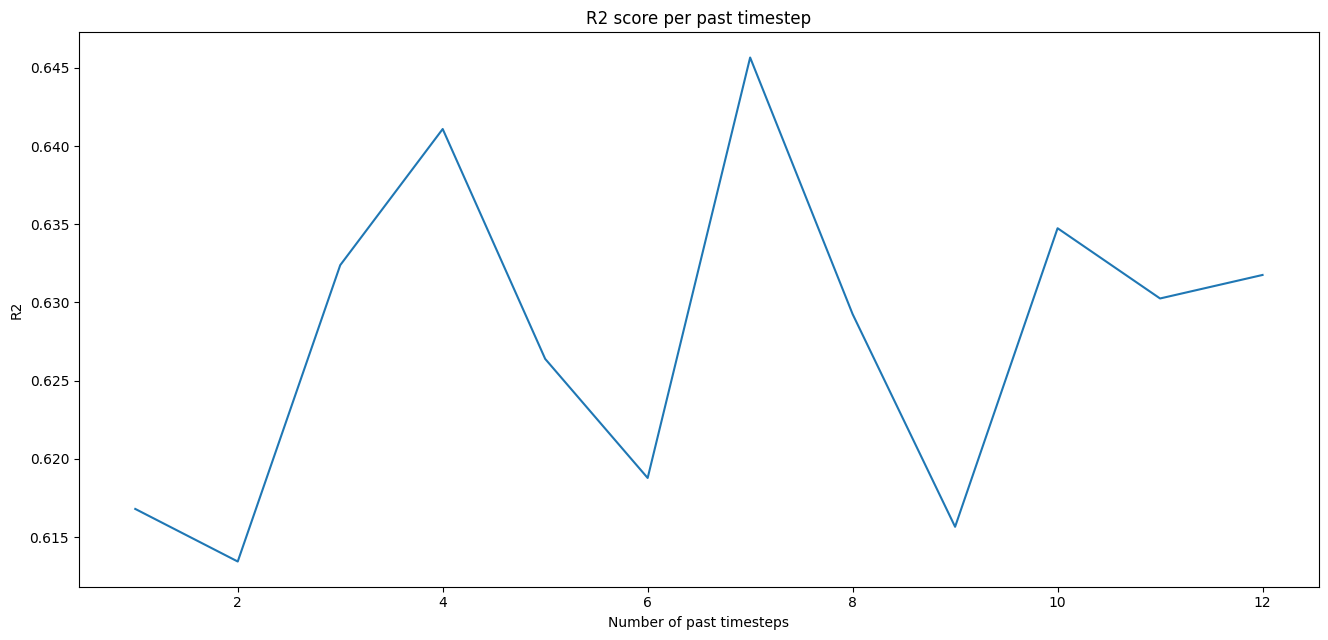

In [22]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), r2_list)
plt.title('R2 score per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('R2')
plt.show()

# Polynomial Regression

### Test for last 12 energy points (3 hours) degree 2, 3 and 4

In [23]:
degree_list = []
full_start = time.time()
for degree in range(2,5):
    metrics_list = []
    print("\n\t\tDegree ", degree)
    for i in range(1,13):
        start = time.time()
        print("\nIteration ", i)
        X, y = last_energy_points(df_total, i)
        X_train, X_test, y_train, y_test = prepare_polynomial(X, y, deg=degree)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        mse, wape, r2 = predict_results(X_train, X_test, y_train, y_test)
        print()
        metrics_list.append((mse,wape,r2))      
        print("\nElapsed time: %.3f seconds" % (time.time() - start))
    degree_list.append(metrics_list)
print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))


		Degree  2

Iteration  1
(28024, 2) (7007, 2) (28024, 1) (7007, 1)
MSE: 0.4455
SMAPE: 47.8854
WAPE: 357465.8323
R2: 0.6185


Elapsed time: 0.901 seconds

Iteration  2
(28024, 5) (7006, 5) (28024, 1) (7006, 1)
MSE: 0.4558
SMAPE: 48.0894
WAPE: 357424.9635
R2: 0.6162


Elapsed time: 0.746 seconds

Iteration  3
(28023, 9) (7006, 9) (28023, 1) (7006, 1)
MSE: 0.4189
SMAPE: 47.5190
WAPE: 357799.3875
R2: 0.6347


Elapsed time: 0.755 seconds

Iteration  4
(28022, 14) (7006, 14) (28022, 1) (7006, 1)
MSE: 0.4179
SMAPE: 47.7553
WAPE: 357809.3911
R2: 0.6488


Elapsed time: 0.735 seconds

Iteration  5
(28021, 20) (7006, 20) (28021, 1) (7006, 1)
MSE: 0.4271
SMAPE: 47.8669
WAPE: 357251.8957
R2: 0.6299


Elapsed time: 0.742 seconds

Iteration  6
(28020, 27) (7006, 27) (28020, 1) (7006, 1)
MSE: 0.4344
SMAPE: 47.9682
WAPE: 358738.7134
R2: 0.6314


Elapsed time: 0.794 seconds

Iteration  7
(28020, 35) (7005, 35) (28020, 1) (7005, 1)
MSE: 0.4276
SMAPE: 47.6374
WAPE: 357088.2305
R2: 0.6255


Elapsed time:

In [13]:
p_mse_list = []
p_wape_list = []
p_r2_list = []

for j in range(0,3):
    mse_l = []
    rmse_l = []
    mae_l = []
    wape_l = []
    r2_l = []
    
    for i in range(0,12):
        mse_l.append(degree_list[j][i][0])
        wape_l.append(degree_list[j][i][1])
        r2_l.append(degree_list[j][i][2])
    p_mse_list.append(mse_l)
    p_wape_list.append(wape_l)
    p_r2_list.append(r2_l)

## Comparison between Linear and Polynomial

Text(0, 0.5, 'MSE')

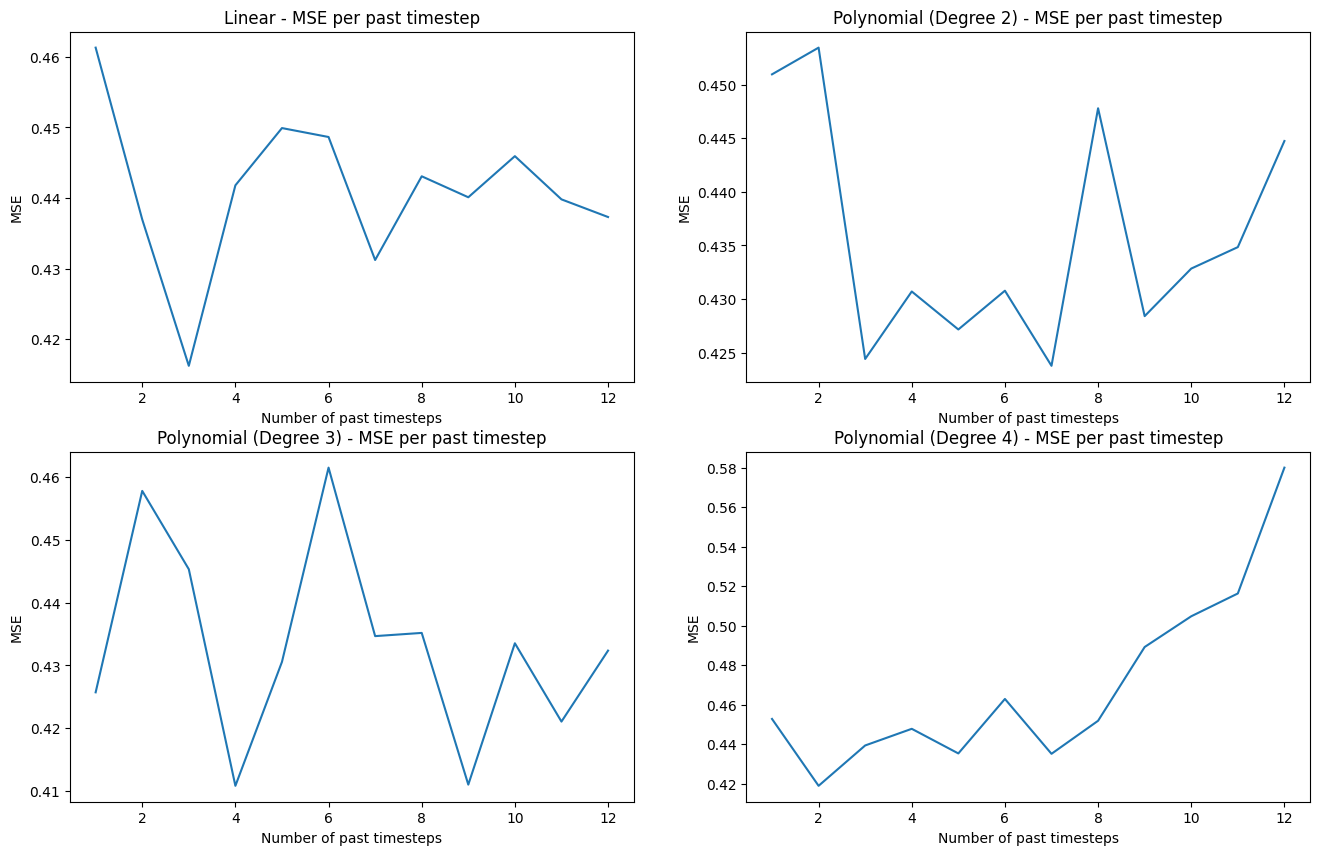

In [14]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), mse_list)
axis[0,0].set_title("Linear - MSE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("MSE")
  
axis[0,1].plot(range(1,13), p_mse_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - MSE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("MSE")

axis[1,0].plot(range(1,13), p_mse_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - MSE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("MSE")

axis[1,1].plot(range(1,13), p_mse_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - MSE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("MSE")

Text(0, 0.5, 'WAPE')

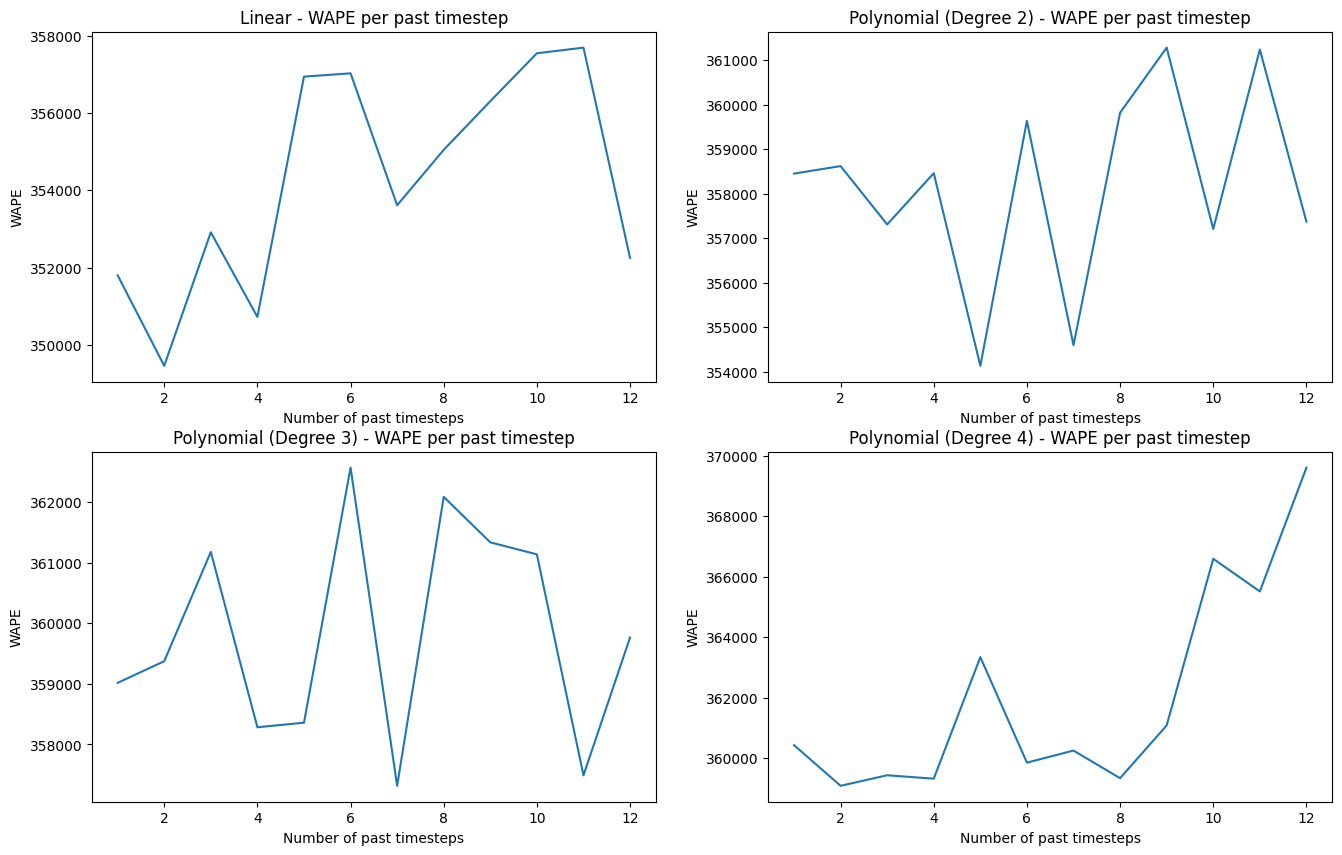

In [15]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), wape_list)
axis[0,0].set_title("Linear - WAPE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("WAPE")
  
axis[0,1].plot(range(1,13), p_wape_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - WAPE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("WAPE")

axis[1,0].plot(range(1,13), p_wape_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - WAPE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("WAPE")

axis[1,1].plot(range(1,13), p_wape_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - WAPE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("WAPE")

Text(0, 0.5, 'R2 score')

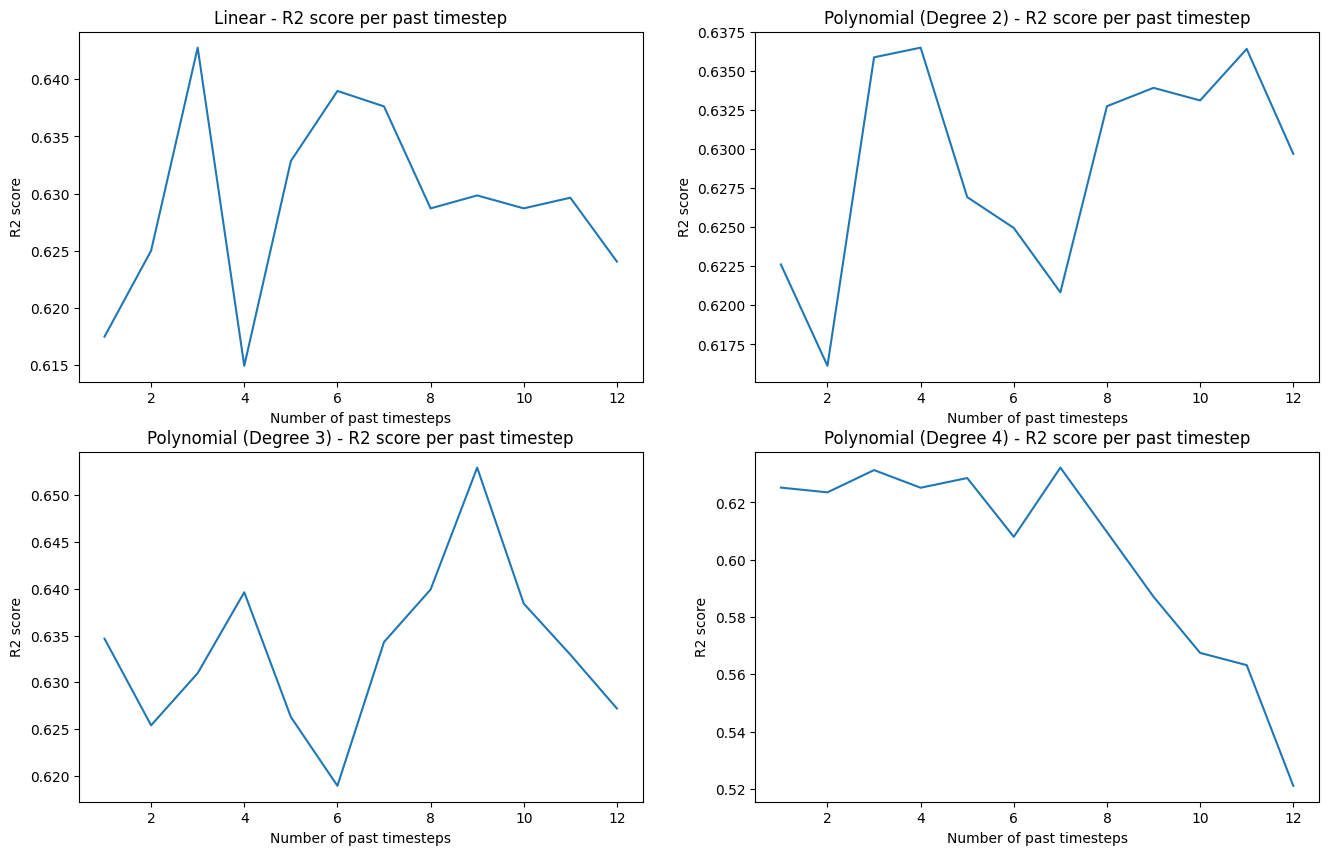

In [16]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), r2_list)
axis[0,0].set_title("Linear - R2 score per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("R2 score")
  
axis[0,1].plot(range(1,13), p_r2_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - R2 score per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("R2 score")

axis[1,0].plot(range(1,13), p_r2_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - R2 score per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("R2 score")

axis[1,1].plot(range(1,13), p_r2_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - R2 score per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("R2 score")